# Rol de las capas ocultas de una ANN

En esta sección se analiza el rendimiento de una red neuronal con una neurona vs el rendimiento de una red neuronal con  con una capa escondida de varias neuronas en un conjunto de datos denominados **moons** los cuales son 2 lunas en un plano, por lo que linealmente no son separables.  
El estudio se realiza para agregar un nivel de procesamiento mayor de los datos y así aprender una representación a utilizar que resuelve satisfactoriamente el problema.

### a) Crear el dataset

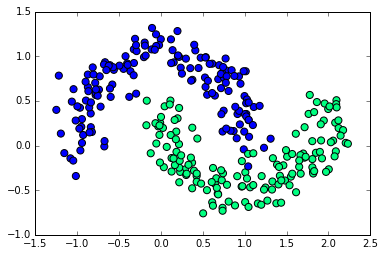

In [134]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
X, y = make_moons(500,noise=0.15)

X_train, y_train = X[:300],y[:300]
X_test, y_test = X[300:],y[300:]

plt.scatter(X_train[:,0], X_train[:,1], s=50, c=y_train, cmap=plt.cm.winter)
#plt.scatter(X_test[:,0], X_test[:,1], s=20, c=y_test, cmap=plt.cm.Spectral)
#plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

Para evidenciar el pobre funcionamiento de una neurona individual, se genera una configuración de datos linealmente inseparable. En este caso se trata de dos semi círculos de radio $\sqrt{2}$, uno centrado en (0;0,5) y el otro en (1;0). La entrada ya sea para la neurona o perceptrón, es un conjunto 500 pares ordenados con su respectiva clasificación, un par pertenece a la clase 0 si está en el semicírculo azul y a la clase 1 si está en el semicírculo verde. Se agrega un porcentaje de ruido (15%) para obtener un poco de aleatoridad.

Se comparará la performance (*accuracy*) de una neurona y el perceptrón en el problema de clasificación de los datos en base al error asociado a cada uno de estos.

### b) Única neurona

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD

n_h=1 #1 neurona

def repetir():
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")

    model.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
    #model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    print("\nTest loss (activation sigmoid) = %f"%model.evaluate(X_test, y_test))
    print("---------------------------------------------------------")

    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="softplus"))
    model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")

    model.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
    #model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    print("\nTest loss (activation softplus) = %f"%model.evaluate(X_test, y_test))
    print("---------------------------------------------------------")

    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="tanh"))
    model.compile(optimizer=SGD(lr=0.5), loss="binary_crossentropy")
    model.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
    #model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    print("\nTest loss (activation tanh) = %f"%model.evaluate(X_test, y_test))
    print("---------------------------------------------------------")

for i in range(3):
    print("**Repeticion "+ str(i)+ " del experimento")
    repetir()
#mas arquitecturastpe

Using Theano backend.


**Repeticion 0 del experimento
 32/200 [===>..........................] - ETA: 0s
Test loss (activation sigmoid) = 0.370801
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss (activation softplus) = 0.701564
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss (activation tanh) = 4.358254
---------------------------------------------------------
**Repeticion 1 del experimento
 32/200 [===>..........................] - ETA: 0s
Test loss (activation sigmoid) = 0.366059
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss (activation softplus) = 7.736765
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss (activation tanh) = 0.516801
---------------------------------------------------------
**Repeticion 2 del experimento
 32/2

Se utilizan distintas funciones de activación no lineales: *sigmoidal*, *softplus* y *tanh* para la neurona. como es un problema de clasificación se intenta minimizar la función de pérdida *cross entropy*. El método  de entrenamiento es el *gradiente descendente estocástico* para ambos casos con un tasa de aprendizaje 0.5.

Se ejecuta 3 veces la neurona con las distintas funciones, imprimiendo por pantalla el error asociado a cada función de activación. La neurona con función de activación sigmoidal para los 3 casos se mantiene en un error similar cercano a 37%, es decir, mantiene una tendencia. No así para las otras funciones de activación,dado que a cada repetición, sus errores cambian drásticamente en comparación con el anterior(divergen), mostrándo claramente que esas funciones de activación no logran resolver el problema.

Estos errores son relativamente altos para un problema de clasificación, las funciones de activación para esta única neurona no se comportan de una manera óptima, ya que no es capaz o no tiene el poder para clasificar el problema, debido a la naturaleza linealmente inseparable de este. Aunque se use una función de activación no-lineal, ésta es aplicada luego de un discriminante lineal sobre la representación original de los datos, por lo tanto, no mejorará su rendimiento.

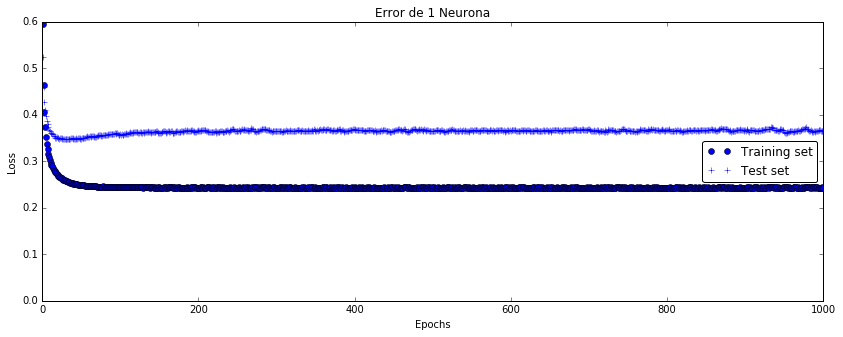

In [8]:
#1 neurona 
n_h = 1 
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], init="uniform", activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.3), loss="binary_crossentropy")
hist1 = model.fit(X_train, y_train, nb_epoch=1000,verbose=0, validation_data=(X_test, y_test))
history_dict1 = hist1.history  
loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo', label = "Training set")
axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Error de 1 Neurona')
axarr.set_ylim(0)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
#f.tight_layout() #separar los subplot
plt.show()

En este gráfico es posible visualizar el error **cross entropy** en función de los *epochs* realizados para entrenar y probar la neurona. Se observa que converge rápidamente a un valor fijo aproximadamente 0,25 en el entrenamiento y 0,35 en el test, donde en mil *epochs* no es posible disminuir el umbrad de error mencionado, implicando que aunque ésta se entrene una gran cantidad de veces, nunca podrá disminuir este error.  
Esto se debe a que con sólo 1 neurona solo se pueden generar fronteras de decisión binarias lineales, es decir, clasifica como 1 o 0 en base a una recta en el espacio de entrada, por lo que esta neurona no puede satisfacer el problema.

### c) Perceptrón multicapas 

In [136]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu',init='uniform'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu', init='uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss="binary_crossentropy")
model.fit(X_train, y_train,nb_epoch=100,  batch_size=32, verbose=0)
score = model.evaluate(X_test, y_test)
print("\nTest loss error (activation relu-relu-sigmoid) = %f"%score)
print("---------------------------------------------------------")

#Relu
perceptron = Sequential()
perceptron.add(Dense(64, input_dim=X_train.shape[1], init='uniform',activation="relu"))
model.add(Dropout(0.01))
perceptron.add(Dense(64, init='uniform',activation="sigmoid"))
perceptron.add(Dense(1,activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=1), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest Test loss error  (activation relu-sigmoid-sigmoid) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")


#Sigmoidal
perceptron = Sequential()
perceptron.add(Dense(64,input_dim=X_train.shape[1], init='uniform',activation="sigmoid"))
model.add(Dropout(0.01))
perceptron.add(Dense(64,init='uniform',activation="sigmoid"))
perceptron.add(Dense(1, init='uniform',activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=1), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest loss error (activation sigmoid-sigmoid-sigmoid) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")

#Softplus
perceptron = Sequential()
perceptron.add(Dense(64, input_dim=X_train.shape[1], init='uniform',activation="softplus"))
model.add(Dropout(0.01))
perceptron.add(Dense(64, init='uniform',activation="softplus"))
perceptron.add(Dense(1, init='uniform',activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=1), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest loss error (activation softplus-softplus-sigmoid) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")

#Tanh
perceptron = Sequential()
perceptron.add(Dense(64, input_dim=X_train.shape[1], init='uniform',activation="tanh"))
model.add(Dropout(0.01))
perceptron.add(Dense(64,init='uniform',activation="tanh"))
perceptron.add(Dense(1, init='uniform',activation="sigmoid"))
perceptron.compile(optimizer=SGD(lr=1), loss="binary_crossentropy")
perceptron.fit(X_train, y_train, nb_epoch=100, batch_size=32, verbose=0)
print("\nTest loss error  (activation tanh-tanh-sigmoid) = %f"%perceptron.evaluate(X_test, y_test))
print("---------------------------------------------------------")

 32/200 [===>..........................] - ETA: 0s
Test loss error (activation relu-relu-sigmoid) = 0.014101
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test Test loss error  (activation relu-sigmoid-sigmoid) = 0.020851
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss error (activation sigmoid-sigmoid-sigmoid) = 0.318737
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss error (activation softplus-softplus-sigmoid) = 0.270398
---------------------------------------------------------
 32/200 [===>..........................] - ETA: 0s
Test loss error  (activation tanh-tanh-sigmoid) = 0.287696
---------------------------------------------------------


En la celda anterior, se utiliza un perceptrón con 2 capas escondidas, cada una con 64 neuronas con el mismo método de entrenamiento. Se presentan distintas funciones de activación en cada capa y se observa una baja considerable de los errores, debido a la arquitectura de la red. Con la incorporación de capas, las neuronas ganan capacidad para aprender a representar el problema, con esto, no necesariamente utilizan el vector de entrada y los pesos de la red como una combinación lineal de estos.
Las dos primeras arquitecturas presentadas poseen un error menor de 1%, mostrándo claramente que este tipo de arquitecturas pueden satisfacer el problema, donde la función que activa la salida de la neurona es conveniente que sea una lineal (*ReLu*).  


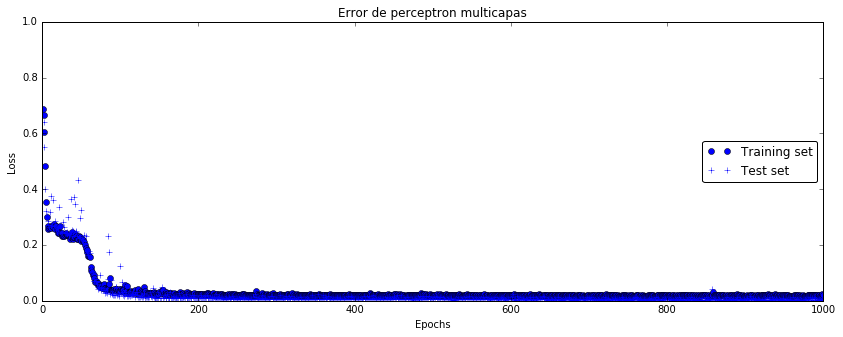

In [135]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu',init='uniform'))
model.add(Dense(64, activation='relu', init='uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.3), loss="binary_crossentropy")
hist2 = model.fit(X_train, y_train,nb_epoch=1000,  batch_size=32, verbose=0, validation_data=(X_test,y_test))

history_dict1 = hist2.history  
loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,5))
axarr.plot(epochs1, loss_values1, 'bo', label = "Training set")
axarr.plot(epochs1, val_loss_values1, 'b+', label = "Test set")
axarr.set_title('Error de perceptron multicapas')
axarr.set_ylim(0,1)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="center right", fancybox= True)
plt.show()

Se puede visualizar en este gráfico el error del perceptrón en función de los *epochs*, a diferencia de la neurona individual, esta si posee la capacidad de separar la representación de lunas. Dado que como fue explicado, las capas ocultas le otorga las facultades a la red de aprender cual es la forma óptima en que puede clasificar la entrada. En consecuencia, el error es evidentemente mucho más bajo que el obtenido con una neurona individual, mostrándose una clara convergencia al óptimo debido a que el error sobre el conjunto de entrenamiento es cercano a 0.  
Se eligió un *learning rate* bajo para la visualización, dado que si se escoje uno muy alto, converge a un error muy bajo en menos de las 100 iteraciones y en las siguientes diverge.  
Con esto se puede determinar que un perceptrón multicapas tiene la capacidad de crear un criterio para separar clases no lineales, es decir, crear fronteras no lineales a través de las representaciones aprendidadas con el entrenamiento.